In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_process import rolling_split
import matplotlib.pyplot as plt
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("./Data/EURUSD_Macro.csv")
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.dropna(inplace=True)


df_tech = pd.read_csv("./Data/EURUSD_OHLC.csv")
# df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])
# df_tech = df_tech[df_tech["Dates"] > pd.to_datetime("2002-01-01") ] 

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)

import sys
import os
sys.path.append("./factors")
import tech_indicators

EURUSD_close = df_tech['PX_LAST'].to_numpy()
EURUSD_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[50]],"RSI":[[10],[50],[100]],"MACD":[[26,12],[12,5]],"ROC":[[2]],"Bollinger_Bands_lower":[[20],[50]],
             "Bollinger_Bands_upper":[[20],[100]],
              "CCI":[[20],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_close,getattr(tech_indicators,key),*value)
    
df_tech.dropna(inplace=True,ignore_index=True)

df_tech_part = df_tech.iloc[:,7:]

df_tech_part["Dates"] = df_tech["Dates"]

df_tech = df_tech_part

df = pd.merge(left=df_Macro,right=df_tech,how="left",on="Dates")

df["EURUSD 1M skew"] = df["EURUSD 1M 25DC"]-df["EURUSD 1M 25DP"]
df["10Y spread"] = df['GTEUR10Y Govt']-df["USGG10YR Index"]
df["30Y spread"] = df['USGG30YR Index']-df['GTEUR30Y Govt']

df

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,DXY Curncy,GOLDS Comdty,USGG2YR Index,USGG5YR Index,USGG10YR Index,...,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_100,CCI_20,CCI_100,EURUSD 1M skew,10Y spread,30Y spread
0,1/3/2003,1.0358,1.0437,1.0342,1.0428,102.470,351.25,1.7499,2.9682,4.0169,...,0.006369,1.005169,0.975757,1.054751,1.037481,74.818425,178.282053,0.00,0.3161,-0.0189
1,1/6/2003,1.0420,1.0491,1.0416,1.0456,101.970,351.25,1.7983,3.0239,4.0518,...,0.002685,1.007637,0.976661,1.055753,1.039133,97.539778,191.086140,0.01,0.2602,-0.0021
2,1/7/2003,1.0450,1.0456,1.0401,1.0409,102.570,347.25,1.7418,2.9751,4.0053,...,-0.004495,1.011543,0.978020,1.055117,1.040498,67.266666,172.037203,0.00,0.2807,0.0051
3,1/8/2003,1.0405,1.0534,1.0363,1.0499,101.870,353.63,1.7257,2.9995,4.0169,...,0.008646,1.015610,0.979030,1.055170,1.042307,88.641750,181.333106,0.00,0.2551,0.0552
4,1/9/2003,1.0500,1.0538,1.0463,1.0485,101.940,352.75,1.8552,3.1747,4.1790,...,-0.001333,1.017903,0.979771,1.055867,1.043833,101.709240,185.412962,0.00,0.1050,0.1734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5597,6/18/2024,1.0734,1.0761,1.0710,1.0740,105.256,2329.46,4.7120,4.2431,4.2227,...,0.000559,1.069795,1.061241,1.092745,1.094931,-110.795455,-67.966065,-1.52,-1.8277,1.8091
5598,6/19/2024,1.0740,1.0753,1.0725,1.0744,105.254,2328.16,4.7120,4.2431,4.2227,...,0.000372,1.069031,1.061244,1.092719,1.094892,-91.733650,-62.640375,-1.47,-1.8197,1.8011
5599,6/20/2024,1.0745,1.0749,1.0702,1.0702,105.588,2360.09,4.7372,4.2746,4.2594,...,-0.003909,1.067593,1.061130,1.093027,1.094770,-105.761354,-85.628493,-1.43,-1.8284,1.8042
5600,6/21/2024,1.0702,1.0721,1.0671,1.0693,105.796,2321.98,4.7322,4.2742,4.2554,...,-0.000841,1.066134,1.061488,1.092946,1.094814,-116.238059,-107.213253,-1.39,-1.8474,1.8021


In [2]:
split_point = int(df.shape[0]*0.9)
df_train = df.iloc[:split_point,:]
df_test = df.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

from data_process import splitting_entropy,threshold_search

threshold = threshold_search(y_train,1e-6)

print(threshold)

# set the threshold manually

from data_process import labelize

y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))
test_set_value = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = train_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

0.001949
1662
1666
1692


In [3]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':2,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.5}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cpu')

net_test.to(device=device,dtype=torch.float64)

net_test.load_state_dict(torch.load("./trained_model/Mix_LSTM.pth"))

net_test

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_Net(
  (LSTM_layer): LSTM(42, 32, batch_first=True, dropout=0.5)
  (linear_stock): Sequential(
    (0): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [4]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))

net_test.eval()
predict_raw_probability = F.softmax(net_test(test_set[:][0]),dim=-1)
predict_probability = (torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0])

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]
real_results_2 = torch.where(test_set_value[:][1]>=0,2,0)

accuracy_score(real_results,predict_results)

0.412962962962963

In [5]:
act_threshold_rate = np.percentile((predict_probability.detach().numpy()),70)

act_predict_bool = (predict_results != 1) & (predict_probability > act_threshold_rate)
print(f"act threshold rate is: {act_threshold_rate}")
print(f"act times rate is: {len(np.nonzero(act_predict_bool))/len(real_results)*100}%")
act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]
act_real_results_2 = real_results_2[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)

act threshold rate is: 0.42329859235865824
act times rate is: 5.0%


0.5185185185185185

In [6]:
accuracy_score(act_predict_results,act_real_results_2)

0.6296296296296297

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


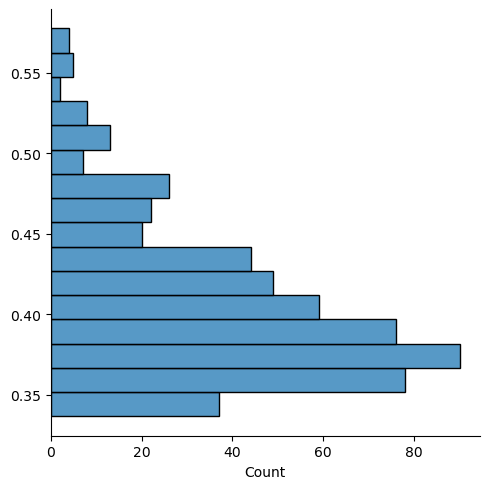

In [7]:
import matplotlib.pyplot as plt
import seaborn

seaborn.displot(y=predict_probability.detach().numpy()
                )

plt.show()

In [8]:
df_test.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'DXY Curncy',
       'GOLDS Comdty', 'USGG2YR Index', 'USGG5YR Index', 'USGG10YR Index',
       'USGG30YR Index', 'GTEUR10Y Govt', 'GTEUR30Y Govt', 'FEDL01 Index',
       'SPX Index', 'SX5E Index', 'UKX Index', 'CAC Index', 'DAX Index',
       'EURUSD 1M 25DC', 'EURUSD 1M 25DP', 'EURUSDV1M ATM', 'EURUSDV1W ATM',
       'EUR1M Curncy', 'EUR12M Curncy', 'Last_Return', 'Predict_Return',
       'SMA_10', 'EMA_50', 'RSI_10', 'RSI_50', 'RSI_100', 'MACD_26_12',
       'MACD_12_5', 'ROC_2', 'Bollinger_Bands_lower_20',
       'Bollinger_Bands_lower_50', 'Bollinger_Bands_upper_20',
       'Bollinger_Bands_upper_100', 'CCI_20', 'CCI_100', 'EURUSD 1M skew',
       '10Y spread', '30Y spread'],
      dtype='object')

In [9]:
df_test.reset_index(inplace=True,drop=True)

df_test_result = df_test.loc[(time_delta-1):,['Dates','Predict_Return','USGG10YR Index','GTEUR10Y Govt']].copy()
df_test_result["rate_diff"] = (df_test_result['GTEUR10Y Govt']-df_test_result['USGG10YR Index'])/100/252
df_test_result.reset_index(drop=True,inplace=True)

df_test_result.drop(columns=['GTEUR10Y Govt','USGG10YR Index'],inplace=True)

df_test_result.rename(columns={'Predict_Return':'Real_Return'},inplace=True)

In [10]:
columns_list = ["predict_down_rate","predict_fluct_rate","predict_up_rate"]

for i in range(len(columns_list)):
    df_test_result[columns_list[i]] = predict_raw_probability[:,i].detach().numpy()
    
    
df_test_result

,Dates,Real_Return,rate_diff,predict_down_rate,predict_fluct_rate,predict_up_rate
0,5/31/2022,-0.007826,-0.000068,0.427449,0.295805,0.276746
1,6/1/2022,0.009108,-0.000068,0.398863,0.326458,0.274679
2,6/2/2022,-0.002605,-0.000066,0.439705,0.263054,0.297240
3,6/3/2022,-0.002146,-0.000066,0.425644,0.287494,0.286861
4,6/6/2022,0.000654,-0.000068,0.421112,0.287960,0.290928
...,...,...,...,...,...,...
535,6/18/2024,0.000372,-0.000073,0.337435,0.404453,0.258112
536,6/19/2024,-0.003909,-0.000072,0.331449,0.419471,0.249081
537,6/20/2024,-0.000841,-0.000073,0.315938,0.439381,0.244682
538,6/21/2024,0.003741,-0.000073,0.321669,0.428244,0.250087


In [11]:
# act just as predict result

df_test_result["predict_action"] = np.where(predict_results.detach().numpy()==0,"short",
                                            np.where(predict_results.detach().numpy()==2,"long","no_act"))

df_test_result["pnl_change"] = np.where(predict_results.detach().numpy()==2,(df_test_result["Real_Return"]+df_test_result["rate_diff"])
                                        .to_numpy(),
                                        np.where(predict_results.detach().numpy()==0,-((df_test_result["Real_Return"]+df_test_result["rate_diff"])
                                                                                       .to_numpy()),0))

df_test_result["pnl"] = df_test_result["pnl_change"].cumsum()

df_test_result

,Dates,Real_Return,rate_diff,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl
0,5/31/2022,-0.007826,-0.000068,0.427449,0.295805,0.276746,short,0.007894,0.007894
1,6/1/2022,0.009108,-0.000068,0.398863,0.326458,0.274679,short,-0.009040,-0.001146
2,6/2/2022,-0.002605,-0.000066,0.439705,0.263054,0.297240,short,0.002672,0.001526
3,6/3/2022,-0.002146,-0.000066,0.425644,0.287494,0.286861,short,0.002212,0.003738
4,6/6/2022,0.000654,-0.000068,0.421112,0.287960,0.290928,short,-0.000586,0.003152
...,...,...,...,...,...,...,...,...,...
535,6/18/2024,0.000372,-0.000073,0.337435,0.404453,0.258112,no_act,0.000000,0.076754
536,6/19/2024,-0.003909,-0.000072,0.331449,0.419471,0.249081,no_act,0.000000,0.076754
537,6/20/2024,-0.000841,-0.000073,0.315938,0.439381,0.244682,no_act,0.000000,0.076754
538,6/21/2024,0.003741,-0.000073,0.321669,0.428244,0.250087,no_act,0.000000,0.076754


In [12]:
action_signal = (np.max(predict_raw_probability.detach().numpy(),axis=-1)>act_threshold_rate) & (
    predict_results.detach().numpy() !=1 )

df_test_result["strategy_action"] =  np.where(~action_signal,"no_act",
                                            np.where(predict_results.detach().numpy()==2,"long","short"))

df_test_result

,Dates,Real_Return,rate_diff,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl,strategy_action
0,5/31/2022,-0.007826,-0.000068,0.427449,0.295805,0.276746,short,0.007894,0.007894,short
1,6/1/2022,0.009108,-0.000068,0.398863,0.326458,0.274679,short,-0.009040,-0.001146,no_act
2,6/2/2022,-0.002605,-0.000066,0.439705,0.263054,0.297240,short,0.002672,0.001526,short
3,6/3/2022,-0.002146,-0.000066,0.425644,0.287494,0.286861,short,0.002212,0.003738,short
4,6/6/2022,0.000654,-0.000068,0.421112,0.287960,0.290928,short,-0.000586,0.003152,no_act
...,...,...,...,...,...,...,...,...,...,...
535,6/18/2024,0.000372,-0.000073,0.337435,0.404453,0.258112,no_act,0.000000,0.076754,no_act
536,6/19/2024,-0.003909,-0.000072,0.331449,0.419471,0.249081,no_act,0.000000,0.076754,no_act
537,6/20/2024,-0.000841,-0.000073,0.315938,0.439381,0.244682,no_act,0.000000,0.076754,no_act
538,6/21/2024,0.003741,-0.000073,0.321669,0.428244,0.250087,no_act,0.000000,0.076754,no_act


In [13]:
df_test_result["pnl_strategy_change"] = np.where(df_test_result["strategy_action"].to_numpy()=="long",
                                                 (df_test_result["Real_Return"]+df_test_result["rate_diff"]).to_numpy(),
                                        np.where(df_test_result["strategy_action"].to_numpy()=="short",
                                                 -((df_test_result["Real_Return"]+df_test_result["rate_diff"]).to_numpy()),0))

df_test_result["pnl_strategy"] = df_test_result["pnl_strategy_change"].cumsum()

df_test_result

,Dates,Real_Return,rate_diff,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl,strategy_action,pnl_strategy_change,pnl_strategy
0,5/31/2022,-0.007826,-0.000068,0.427449,0.295805,0.276746,short,0.007894,0.007894,short,0.007894,0.007894
1,6/1/2022,0.009108,-0.000068,0.398863,0.326458,0.274679,short,-0.009040,-0.001146,no_act,0.000000,0.007894
2,6/2/2022,-0.002605,-0.000066,0.439705,0.263054,0.297240,short,0.002672,0.001526,short,0.002672,0.010566
3,6/3/2022,-0.002146,-0.000066,0.425644,0.287494,0.286861,short,0.002212,0.003738,short,0.002212,0.012778
4,6/6/2022,0.000654,-0.000068,0.421112,0.287960,0.290928,short,-0.000586,0.003152,no_act,0.000000,0.012778
...,...,...,...,...,...,...,...,...,...,...,...,...
535,6/18/2024,0.000372,-0.000073,0.337435,0.404453,0.258112,no_act,0.000000,0.076754,no_act,0.000000,0.023995
536,6/19/2024,-0.003909,-0.000072,0.331449,0.419471,0.249081,no_act,0.000000,0.076754,no_act,0.000000,0.023995
537,6/20/2024,-0.000841,-0.000073,0.315938,0.439381,0.244682,no_act,0.000000,0.076754,no_act,0.000000,0.023995
538,6/21/2024,0.003741,-0.000073,0.321669,0.428244,0.250087,no_act,0.000000,0.076754,no_act,0.000000,0.023995


In [14]:
# df_test_result.to_csv("./Data/test_result.csv")